# Faded, Torn, Rotated Receipt OCR with Image Preprocessing
## How to extract specific information from faded, torn, rotated receipts?
### https://medium.com/@jaelin_75015/faded-torn-rotated-receipt-ocr-with-image-preprocessing-1fb03c036504

## Enhanced Grocery Receipt — Run OCR With Preprocessing
### 1. Install Numpy, OpenCV, imutils, Pillow

Create and activate a virtual environment.  
Execute script install_packages.sh   
`sh install_packages`

In [3]:
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

raw_path = 'raw/20240207_154100_rotated90.jpg' # Enter the path to your scanned receipt
raw_img = cv2.imread(raw_path)



### 2. Load Image

raw_img JPG/PNG image path is converted to Numpy array.   
cv2.imread() OpenCV reads image in BGR scheme by default.   
cv2.cvtColor() To view the image in RGB scheme.   

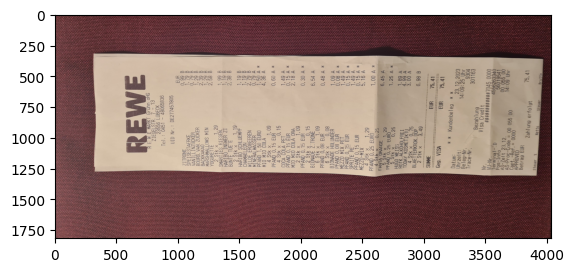

In [4]:
# View the image in RGB
raw_rgb = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
plt.imshow(raw_rgb)
plt.show()

### 3. Orient Receipt to Vertical (Optional)

Sometimes, the loaded image is in landscape orientation. If it is, we correct this first.

Orientation — Image orientation information is stored in metadata of the image file. However, Python libraries we use to read the image may not have access to the metadata. That’s why sometimes we see mis-oriented images.
(height, width, channels) — OpenCV opened image with .shape is in this format. Pillow opened image with .size is in (width, height) format.
imutils.rotate() — This function is compatible with OpenCV opened images, but not with Pillow opened images. This is becuase it reuqires shape information.

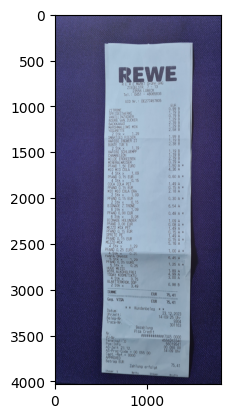

In [5]:
def orient_vertical(img):
    width = img.shape[1]
    height = img.shape[0]
  
    if width > height:
      rotated = imutils.rotate_bound(img, angle=90)
    else:
      rotated = img
    return rotated

rotated = orient_vertical(raw_img)

plt.imshow(rotated)
plt.show()

### 4. Sharpen Receipt Edge — Gray, Blur, Dilate, Canny

To detect the contour of the receipt, first we need to binarize the image. To binarize, we should convert the image to grayscale (Gray) and remove all the texts and other small objects from the scanned receipt (Blur, Dilate). Then, we sharpen the edges to easily detect the receipt contour (Canny).

**Gray** — To convert pixel values from BGR/RGB colour representation to brightness representation. It is achieved by converting pixel values from3-channels (0–255, 0–255, 0–255) to 1-channel (0–255).   
**Blur** — To remove fine objects (i.e. text) from the scanned receipt so that only the receipt shape will be detected as a contour.   
**Dilate** — To further remove fine objects (i.e. text) from the scanned receipt. Dilation is used to expand the boundaries of an object in an image, or to fill in small gaps or holes within an object.   
**Canny** — To sharpen the edge of the receipt.   
**CAUTION:** White background — If preprocessing step includes dilation, the receipt contour will become undetectable. White background will result in an incorrectly cropped receipt — In turn, poor OCR result. Error handing is required if deployed to production to catch failed cropping and zero character output of OCR.

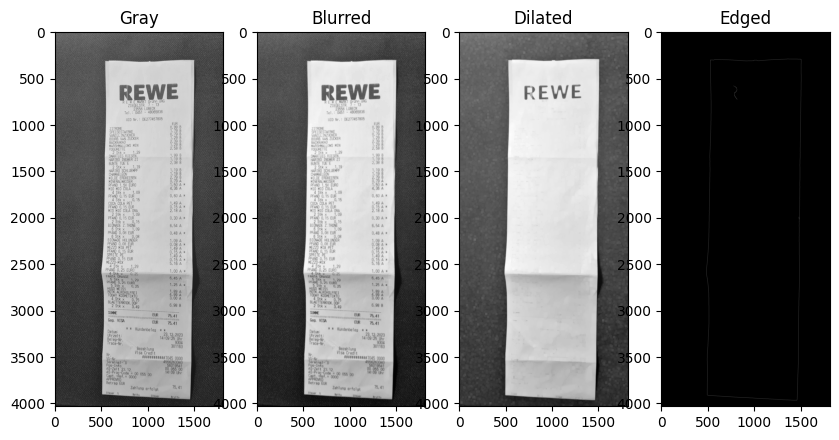

In [6]:
def sharpen_edge(rotated):
    gray = cv2.cvtColor(rotated, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (15, 15), 0)
    rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (11, 11))
    dilated = cv2.dilate(blurred, rectKernel, iterations=2)
    edged = cv2.Canny(dilated, 75, 200, apertureSize=3)

    plt.figure(figsize=(10, 10))

    plt.subplot(1, 4, 1)  # 1 row, 3 columns, 1st subplot
    plt.imshow(gray, cmap='gray')
    plt.title('Gray')

    plt.subplot(1, 4, 2)  # 1 row, 3 columns, 1st subplot
    plt.imshow(blurred, cmap='gray')
    plt.title('Blurred')

    plt.subplot(1, 4, 3)  # 1 row, 3 columns, 2nd subplot
    plt.imshow(dilated, cmap='gray')
    plt.title('Dilated')

    plt.subplot(1, 4, 4)  # 1 row, 3 columns, 3rd subplot
    plt.imshow(edged, cmap='gray')
    plt.title('Edged')

    plt.show()

    return edged


edged = sharpen_edge(rotated)

### 5. Binarize (Black & White)   
   
**threshold**  — Apply threshold to reassign each pixel value to 0 or 255. If threshold is set to 100, any pixels between 0–100 will become black (0), and any pixels between 100–255 will become white (255).  
    
**rectKernel** — To thicken the edges of the receipt, increase the kernel size. Choose (15,15) instead of (1,1).      
  
**thresh** This is the actual threshold used for cv2.threshold() operation. This should be identical as threshold value.   
   
**binary** This is the output. Binarized image in numpy array format.

In [17]:
def binarize(img, threshold):
    threshold = np.mean(img)
    print(threshold)
    thresh, binary = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)
    rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
    dilated = cv2.dilate(binary, rectKernel, iterations=2)
    print(f"cv2.threshold is {thresh}, average threshold of the image was {threshold}." )
    return dilated

threshold = 100 # its only used if mean is out commented
binary = binarize(edged, threshold)

0.32969790683343825
cv2.threshold is 0.0, average threshold of the image was 0.32969790683343825.


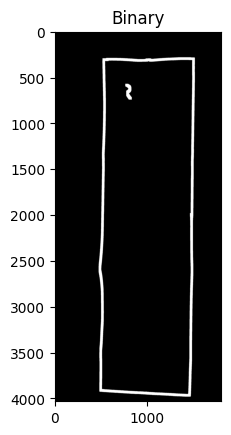

In [18]:
plt.imshow(binary, cmap='gray')
plt.title('Binary')

plt.show()

### 6. Draw Bounding box   
   
**rect** (cx, cy), (w, h) , a   
**box** (top-left, top-right, bottom-right, bottom-left)   
**Largest Contour** —To select based on the area, which will account for both closed and open contours (cv2.contourArea).

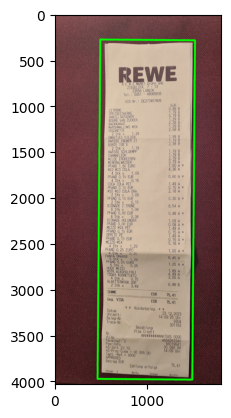

In [19]:
def find_receipt_bounding_box(binary, img):
    global largest_cnt
    # Finds contours in the binary image
    contours, hierarchy = cv2.findContours(
        binary, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    # Selects the contour with the largest area
    largest_cnt = max(contours, key=cv2.contourArea)
    # Finds the smallest enclosing rectangle of the largest contour
    rect = cv2.minAreaRect(largest_cnt)
    # Converts the corner points of the rectangle to integers
    box = np.intp(cv2.boxPoints(rect))
    # Draws the rectangle on the image
    boxed = cv2.drawContours(img.copy(), [box], 0, (0, 255, 0), 20)
    return boxed, largest_cnt, rect

boxed, largest_cnt, rect = find_receipt_bounding_box(binary, rotated)
boxed_rgb = cv2.cvtColor(boxed, cv2.COLOR_BGR2RGB)
plt.imshow(boxed_rgb)
plt.show()

### 7. Adjust Tilted Receipt  

Tilted Angle — The concept of angle here is tricky. The starting point of 0 angle is unclear, but adding 90 degree when the angles is < -45 degree seem to correctly adjust the tilted receipt.

In [94]:
def find_tilt_angle(largest_contour):
    angle = rect[2]  # Find the angle of vertical line
    print("Angle_0 = ", round(angle, 1))

    if angle < -45:
        angle += 90 # If the angle is less than -45, 90 is added to correct the angle
        print("Angle_1:", round(angle, 1))
    elif angle > 45:
        angle -= 90 # If the angle is greater than 45, 90 is substracted to correct the angle
        print("Angle_1:", round(angle, 1))
    else:
        uniform_angle = abs(angle) # If the angle is between -45 and 45, the absolute value of the angle is taken
    print("Uniform angle = ", round(uniform_angle, 1))

    return rect, uniform_angle

rect, angle = find_tilt_angle(largest_cnt)

Angle_0 =  0.5
Uniform angle =  0.5


359.53838524222374


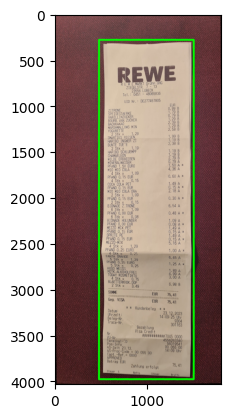

In [95]:
def adjust_tilt(img, angle):
    if angle >= 5 and angle < 80:
        rotated_angle = 0
    elif angle < 5:
        rotated_angle = angle
    else:
        rotated_angle = 270+angle

    tilt_adjusted = imutils.rotate(img, rotated_angle)
    delta = 360-rotated_angle
    return tilt_adjusted, delta


tilted, delta = adjust_tilt(boxed, angle)
print(delta)

tilted_rgb = cv2.cvtColor(tilted, cv2.COLOR_BGR2RGB)
plt.imshow(tilted_rgb, cmap='gray')
plt.show()

### 8. Crop Receipt

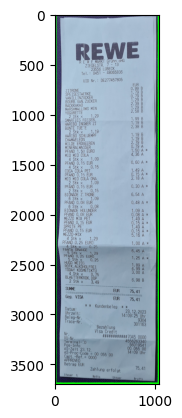

In [96]:
def crop(img, largest_contour):
    x, y, w, h = cv2.boundingRect(largest_contour)
    cropped = img[y:y+h, x:x+w]
    return cropped

cropped = crop(tilted, largest_cnt)
plt.imshow(cropped)
plt.show()

### 9. Enhance Text on Receipt

**Average brightness np.mean(ROI)** — Using average brightness as a threshold value is a good starting point. So, here we calculated the mean of gray-scale pixel values and adjusted it by taking 98% of that value as threshold for binarization (You can experiment with different values). Gamma correction is similar in approach except that it uses log-scale instead.   
   
**Region of Interest (ROI)** — To account for the brightness only within the receipt area, we will take 95% of the cropped image to calculate the average brightness mentioned above.

In [97]:
def enhance_txt(img):
    w = img.shape[1]
    h = img.shape[0]
    w1 = int(w*0.05)
    w2 = int(w*0.95)
    h1 = int(h*0.05)
    h2 = int(h*0.95)
    ROI = img[h1:h2, w1:w2]  # 95% of center of the image
    threshold = np.mean(ROI) * 0.98  # % of average brightness

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (1, 1), 0)
    edged = 255 - cv2.Canny(blurred, 100, 150, apertureSize=7)

    thresh, binary = cv2.threshold(blurred, threshold, 255, cv2.THRESH_BINARY)
    return binary

enhanced = enhance_txt(cropped)
enhanced_rgb = cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB)
plt.imsave('enhanced.jpg', enhanced_rgb)

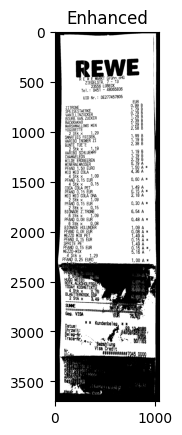

In [99]:
plt.imshow(enhanced, cmap='gray')
plt.title('Enhanced')

plt.show()

### Run OCR — Preprocessed
Overall, preprocessed images showed huge improvement over the baseline. The number of words detected, the number of comprehensible words, and the visual recognition of the text have been enhanced a lot. Now, we can extract information below:

- Individual grocery items
- Store name
- Total price
- Date of purchase
- Card number

### Conclusion
We successfully improved the Tesseract OCR result with image preprocessing steps. We used OpenCV, Pillow, imutils libraries to augment the scanned receipts. Then, we detected the edges of the receipt by starting with operations such as Rotate, Gray, Blur, Dilate, Canny, Binarize, Draw Bounding Box, and Crop. Then, we enhanced the text content of the receipt by obtaining the average brightness of the centre area of the receipt. We also learned the difference between OpenCV and Pillow library when it comes to reading the image shape and the compatibility with imutils package.   
   
Next Step
In my next post, I will show you how to deploy this entire enhanced OCR preprocessing & model pipeline to Flask App and further to GCP micro service – Google Cloud Run – using Docker.